# 8: Working with SCIMAP and Scanpy
Demonstrate analyizing data using spatialcells and SCIMAP together. 

@author: Guihong Wan and Boshen Yan      
@date: Feb 12 2024 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import anndata as ad
import scanpy as sc

import plotly.io as pio
pio.renderers.default = 'browser'

# Before you start, make sure you have installed SCIMAP
# pip install scimap
import scimap as sm
import spatialcells as spc

/Users/ghwan/opt/anaconda3/envs/spatialcells_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
adata = ad.read_h5ad("../../data/MEL1_adata.h5ad")

In [51]:
spc.prep.setGate(adata, "SOX10_cellRingMask", 7.9, debug=True)
spc.prep.setGate(adata, "MITF_cellRingMask", 6.3, debug=True)
spc.prep.setGate(adata, "KERATIN_cellRingMask", 6.4, debug=True)
spc.prep.setGate(adata, "CD3D_cellRingMask", 7, debug=True)

SOX10_cellRingMask_positive
False    566576
True     544009
Name: count, dtype: int64
MITF_cellRingMask_positive
False    851822
True     258763
Name: count, dtype: int64
KERATIN_cellRingMask_positive
False    1067400
True       43185
Name: count, dtype: int64
CD3D_cellRingMask_positive
False    1038559
True       72026
Name: count, dtype: int64


In [52]:
def combine_columns(row):
    if row["MITF_cellRingMask_positive"] and row["SOX10_cellRingMask_positive"]:
        return "SOX10+MITF+"
    elif row["SOX10_cellRingMask_positive"]:
        return "SOX10+MITF-"
    else:
        return "SOX10-"


# Applying the function to create the new phenotype column
adata.obs["pheno"] = adata.obs.apply(combine_columns, axis=1)

# Seperate the tissue into two parts
The tissue was fragmented. Following the original [paper](https://aacrjournals.org/cancerdiscovery/article/12/6/1518/699151/The-Spatial-Landscape-of-Progression-and), we can conduct analyses seperately for the two parts.

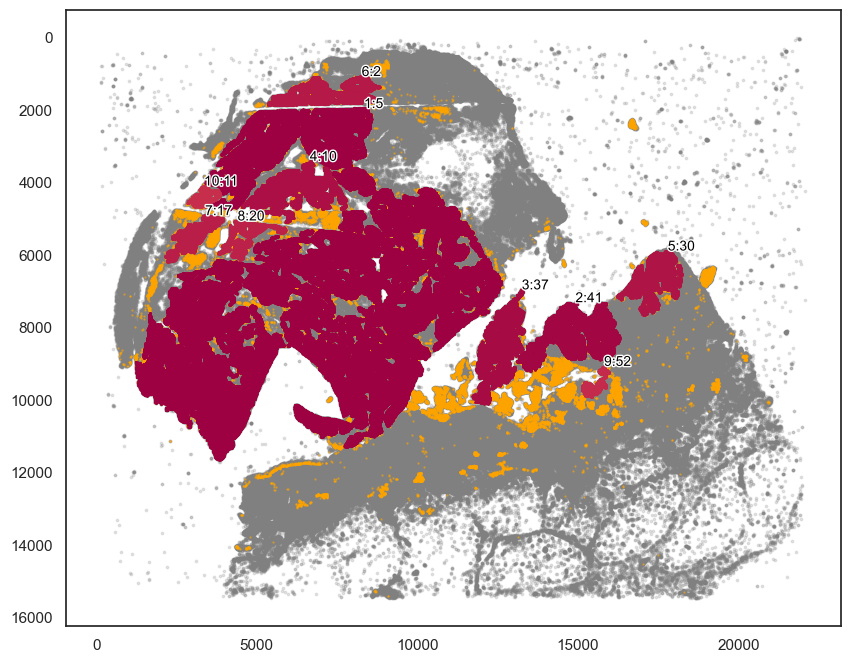

In [53]:
markers_of_interest = ["SOX10_cellRingMask_positive"]

communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(
    adata, markers_of_interest, eps=50, newcolumn=communitycolumn
)
# Plotting the communities
plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

In [54]:
# Here we chose the main tumor area.
communityIndexList = [5, 2, 10, 11, 17, 20]
boundary = spc.spa.getBoundary(adata, communitycolumn, communityIndexList, alpha=150)
pruned_boundary = spc.spa.pruneSmallComponents(
    boundary, min_edges=20, holes_min_edges=200
)

In [56]:
pruned_boundary = spc.spa.getExtendedBoundary(pruned_boundary, 40)

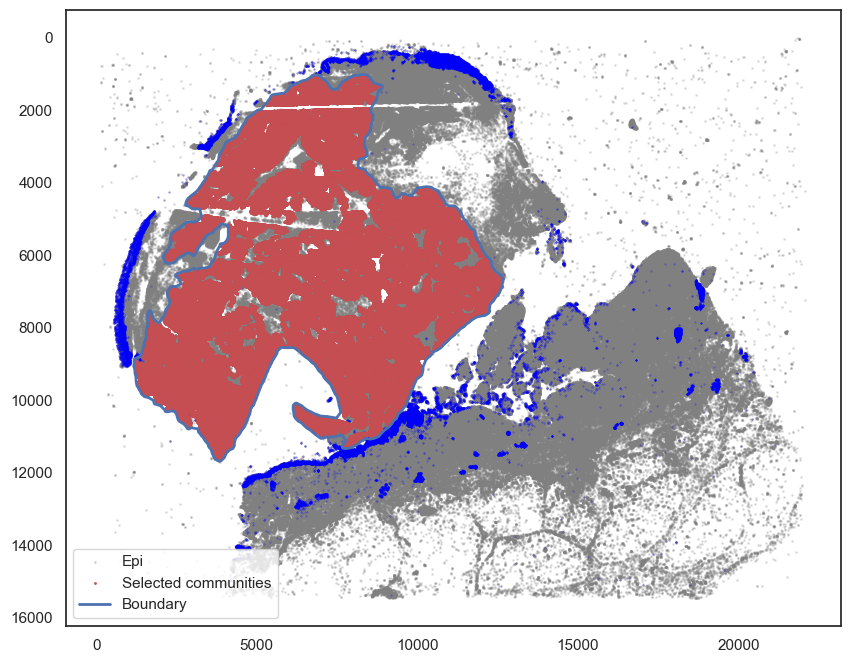

In [57]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

## epi
epi_tmp = adata.obs[adata.obs["KERATIN_cellRingMask_positive"] == True]
ax.scatter(
    *zip(*epi_tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=0.1, color="blue", alpha=0.5, label="Epi"
)

# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
    ["X_centroid", "Y_centroid"]
].to_numpy()
ax.scatter(xy[:, 0], xy[:, 1], s=markersize, color="r", label="Selected communities")

# Bounds of points in selected commnities
spc.plt.plotBoundary(pruned_boundary, ax=ax, linewidth=2, color="b", label="Boundary")
ax.invert_yaxis()
ax.legend(loc="lower left")
plt.show()

In [58]:
regions = ["Tumor"]
boundaries_list = [pruned_boundary]
spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region", default="BG"
)

724356it [01:41, 7148.66it/s]


Assigned points to region: Tumor


In [59]:
adata2 = adata[adata.obs["region"] == "BG"].copy()

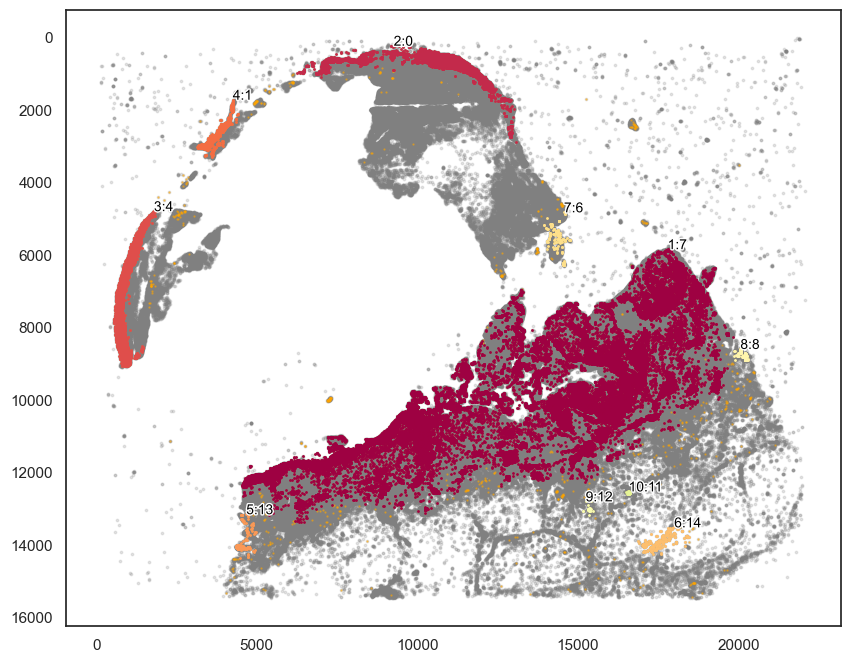

In [87]:
markers_of_interest = ["KERATIN_cellRingMask_positive", "CD3D_cellRingMask_positive"]

communitycolumn = "KOI_community"
ret = spc.spatial.getCommunities(
    adata2, markers_of_interest, eps=300, newcolumn=communitycolumn
)

# Plotting the communities
plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata2,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

In [96]:
communityIndexList = [7,13,8]
boundary2 = spc.spa.getBoundary(adata2, communitycolumn, communityIndexList, alpha=200)
pruned_boundary2 = spc.spa.pruneSmallComponents(
    boundary2, min_edges=20, holes_min_edges=200
)

In [100]:
# You may want to slightly extend the boundary.
pruned_boundary2_extended = spc.spa.getExtendedBoundary(pruned_boundary2, 40)

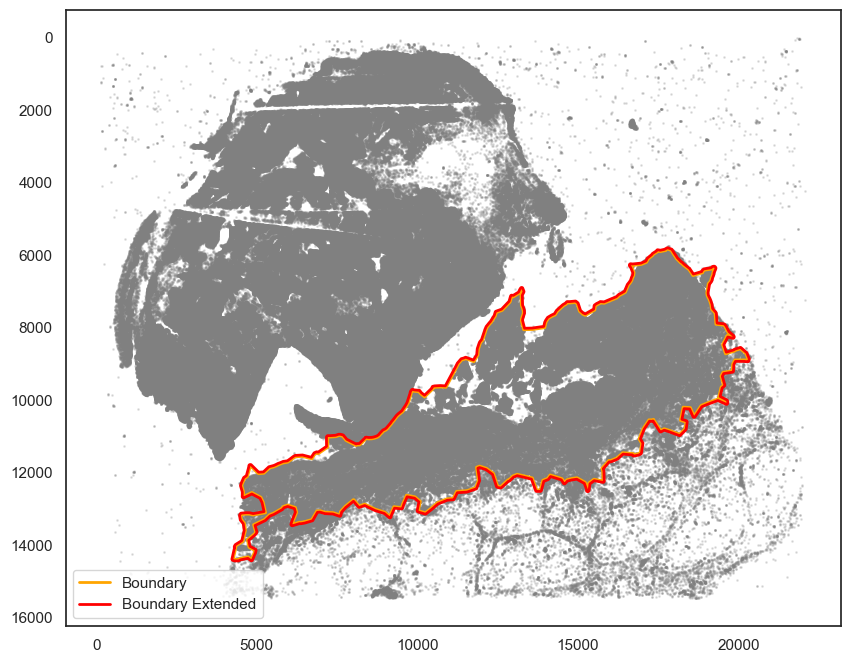

In [101]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

# Bounds of points in selected commnities
spc.plt.plotBoundary(pruned_boundary2, ax=ax, linewidth=2, color="orange", label="Boundary")
spc.plt.plotBoundary(pruned_boundary2_extended, ax=ax, linewidth=2, color="red", label="Boundary Extended")

ax.invert_yaxis()
ax.legend(loc="lower left")
plt.show()

In [102]:
regions = ["Part2"]
boundaries_list = [pruned_boundary2_extended]
spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region", default="BG"
)

681477it [01:01, 11004.91it/s]


Assigned points to region: Part2


In [103]:
adata1 = adata[adata.obs["region"] == "BG"].copy()

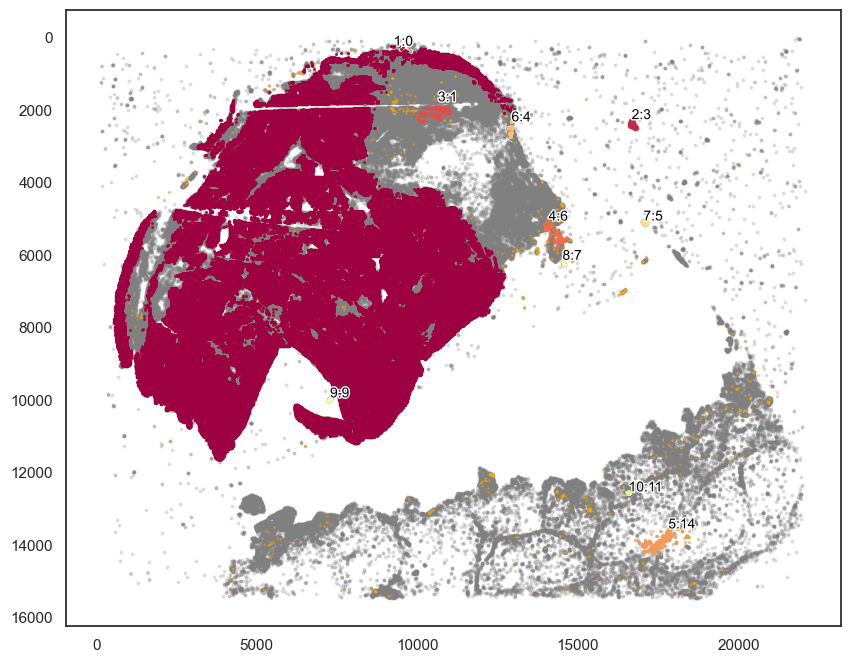

In [112]:
markers_of_interest = ["SOX10_cellRingMask_positive","KERATIN_cellRingMask_positive", "CD3D_cellRingMask_positive"]

markers_of_interest = ["SOX10_cellRingMask_positive"]

communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(
    adata1, markers_of_interest, eps=200, newcolumn=communitycolumn
)

# Plotting the communities
plot_first_n_clusters = 10
fig, ax = plt.subplots(figsize=(10, 8))
spc.plt.plotCommunities(
    adata1,
    ret,
    communitycolumn,
    plot_first_n_clusters=plot_first_n_clusters,
    s=1,
    fontsize=10,
    ax=ax,
)
ax.invert_yaxis()
plt.show()

In [119]:
communityIndexList = [0]
boundary1 = spc.spa.getBoundary(adata1, communitycolumn, communityIndexList, alpha=200)
pruned_boundary1 = spc.spa.pruneSmallComponents(boundary1, min_edges=20, holes_min_edges=200)

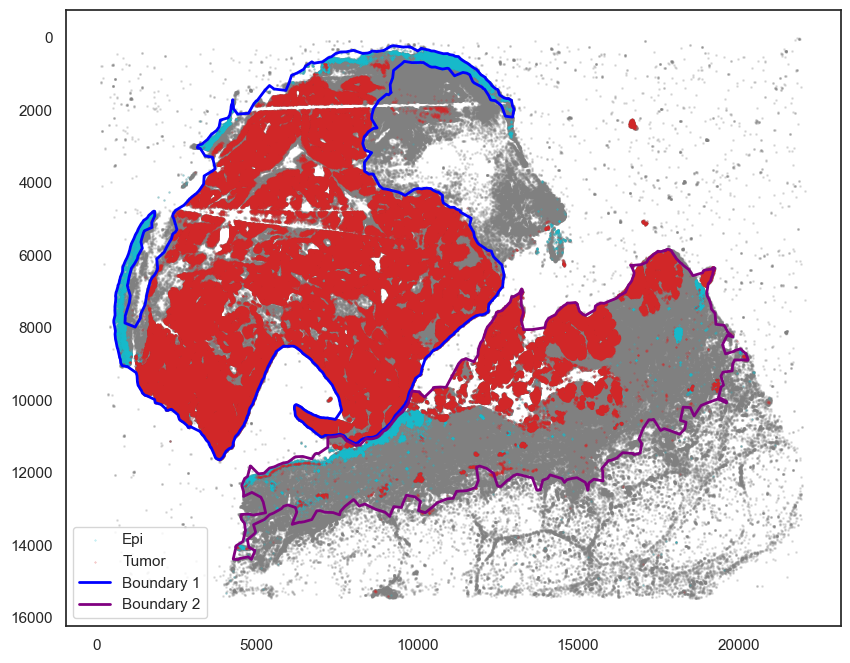

In [127]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

## epi
epi_tmp = adata.obs[adata.obs["KERATIN_cellRingMask_positive"] == True]
ax.scatter(
    *zip(*epi_tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=0.1, color="tab:cyan", alpha=0.5, label="Epi"
)

tmp = adata.obs[adata.obs["SOX10_cellRingMask_positive"] == True]
ax.scatter(
    *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=0.1, color="tab:red", alpha=0.5, label="Tumor"
)

# Bounds of points in selected commnities
spc.plt.plotBoundary(pruned_boundary1, ax=ax, linewidth=2, color="blue", label="Boundary 1")
spc.plt.plotBoundary(pruned_boundary2, ax=ax, linewidth=2, color="purple", label="Boundary 2")

ax.invert_yaxis()
ax.legend(loc="lower left")
plt.show()

# Work with SCANPY to cluster cells in each region

In [ ]:
regions = ["Part1","Part2"]
boundaries_list = [pruned_boundary1, pruned_boundary2]
spc.spatial.assignPointsToRegions(
    adata, boundaries_list, regions, assigncolumn="region", default="BG"
)

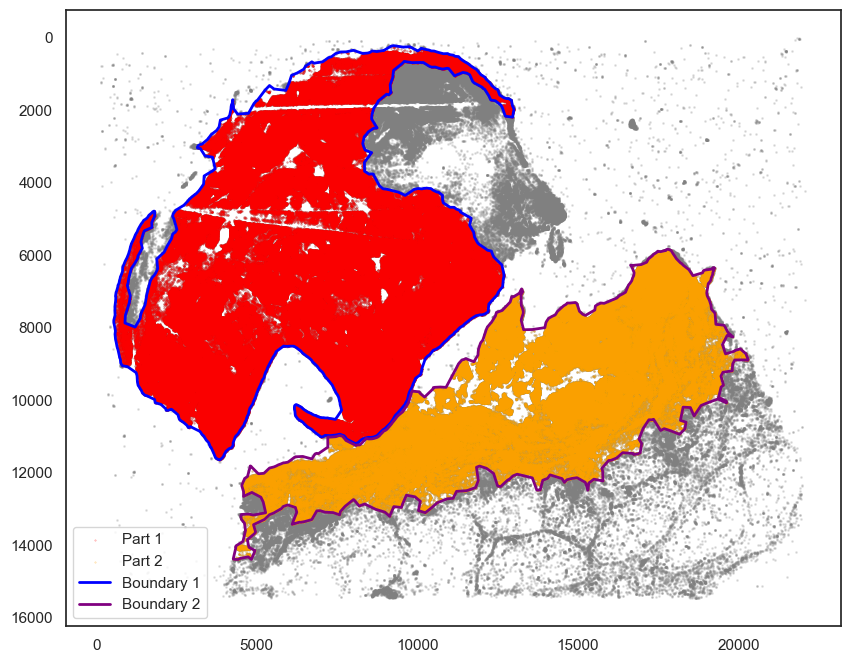

In [126]:
markersize = 1

fig, ax = plt.subplots(figsize=(10, 8))

## all points
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=markersize,
    color="grey",
    alpha=0.2
)

tmp = adata.obs[adata.obs["region"] == "Part1"]
ax.scatter(
    *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=0.1, color="red", alpha=0.5, label="Part 1"
)

tmp = adata.obs[adata.obs["region"] == "Part2"]
ax.scatter(
    *zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()),
    s=0.1, color="orange", alpha=0.5, label="Part 2"
)

# Bounds of points in selected commnities
spc.plt.plotBoundary(pruned_boundary1, ax=ax, linewidth=2, color="blue", label="Boundary 1")
spc.plt.plotBoundary(pruned_boundary2, ax=ax, linewidth=2, color="purple", label="Boundary 2")

ax.invert_yaxis()
ax.legend(loc="lower left")
plt.show()

In [130]:
adata_part1 = adata[adata.obs["region"] == "Part1"].copy()
adata_part1

AnnData object with n_obs × n_vars = 632296 × 6
    obs: 'X_centroid', 'Y_centroid', 'phenotype_large_cohort', 'SOX10_cellRingMask_positive', 'MITF_cellRingMask_positive', 'KERATIN_cellRingMask_positive', 'pheno', 'COI_community', 'region', 'CD3D_cellRingMask_positive'
    uns: 'all_markers'

In [131]:
adata_part2 = adata[adata.obs["region"] == "Part2"].copy()
adata_part2

AnnData object with n_obs × n_vars = 356569 × 6
    obs: 'X_centroid', 'Y_centroid', 'phenotype_large_cohort', 'SOX10_cellRingMask_positive', 'MITF_cellRingMask_positive', 'KERATIN_cellRingMask_positive', 'pheno', 'COI_community', 'region', 'CD3D_cellRingMask_positive'
    uns: 'all_markers'

In [138]:
# Since the sc.tl.umap() is too slow, here we do sampling of the cells

sc.pp.subsample(adata_part1, n_obs=10000, random_state=42)
sc.pp.subsample(adata_part2, n_obs=10000, random_state=42)
adata_part1

AnnData object with n_obs × n_vars = 10000 × 6
    obs: 'X_centroid', 'Y_centroid', 'phenotype_large_cohort', 'SOX10_cellRingMask_positive', 'MITF_cellRingMask_positive', 'KERATIN_cellRingMask_positive', 'pheno', 'COI_community', 'region', 'CD3D_cellRingMask_positive'
    uns: 'all_markers', 'neighbors'
    obsp: 'distances', 'connectivities'

In [139]:
# Construct the neighborhood graph
sc.pp.neighbors(adata_part1, n_neighbors=30, n_pcs=5)
# Cluster the neighborhood graph
sc.tl.leiden(adata_part1, resolution = 1)
# UMAP
sc.tl.umap(adata_part1)

In [143]:
# Construct the neighborhood graph
sc.pp.neighbors(adata_part2, n_neighbors=30, n_pcs=5)
# Cluster the neighborhood graph
sc.tl.leiden(adata_part2, resolution = 1)
# UMAP
sc.tl.umap(adata_part2)

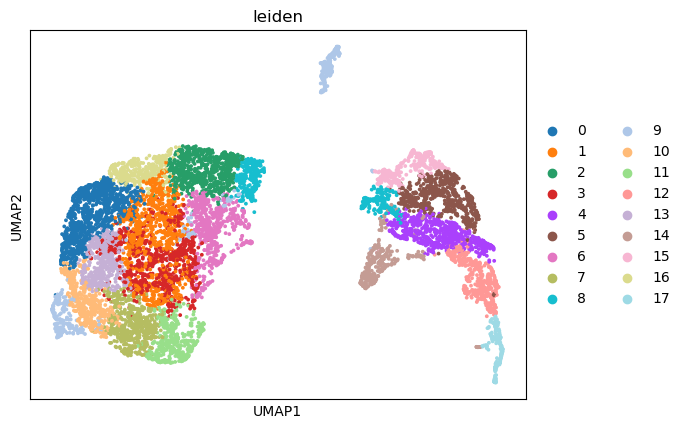

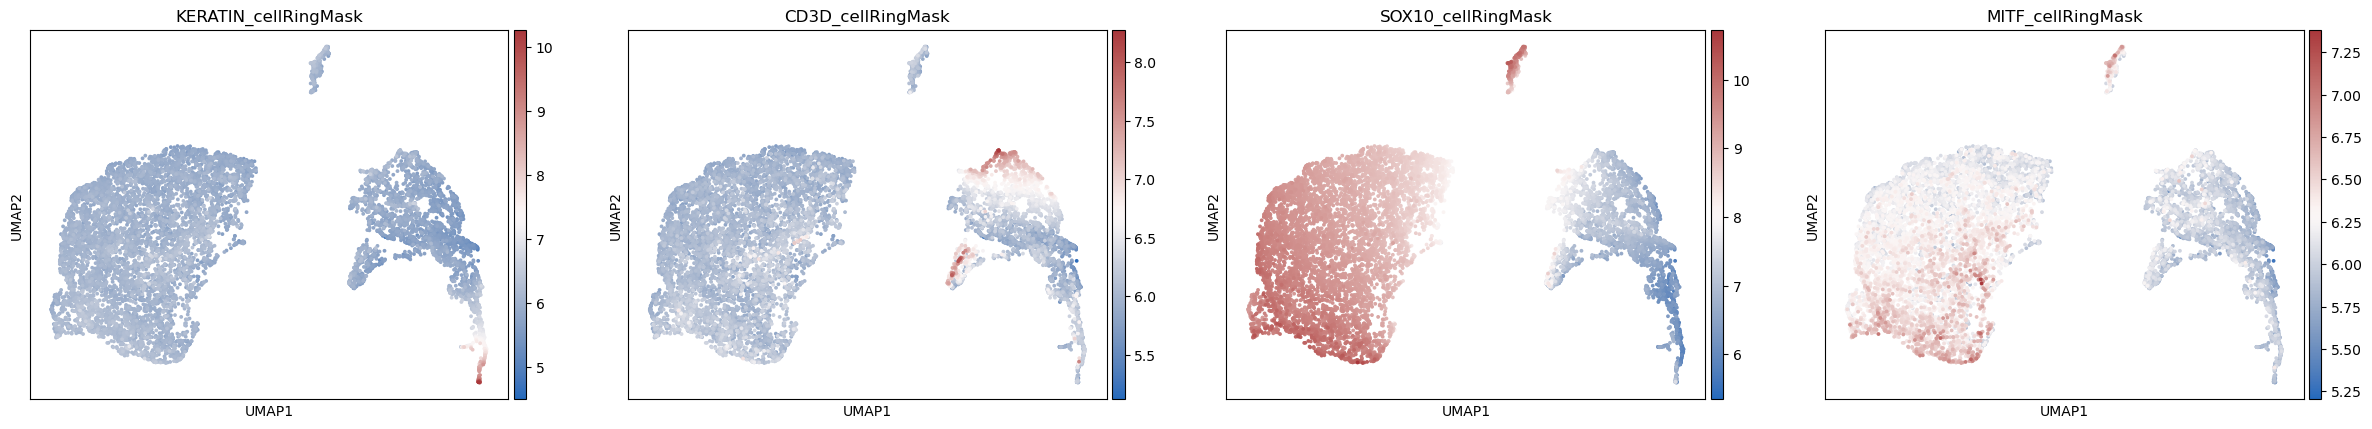

In [163]:
import warnings
warnings.filterwarnings('ignore')

sc.pl.umap(adata_part1, color=['leiden'], 
           cmap= 'vlag', use_raw=False, s=30) 
sc.pl.umap(adata_part1, color=['KERATIN_cellRingMask', 'CD3D_cellRingMask', 
                               'SOX10_cellRingMask','MITF_cellRingMask'], 
           cmap= 'vlag', use_raw=False, s=30) 

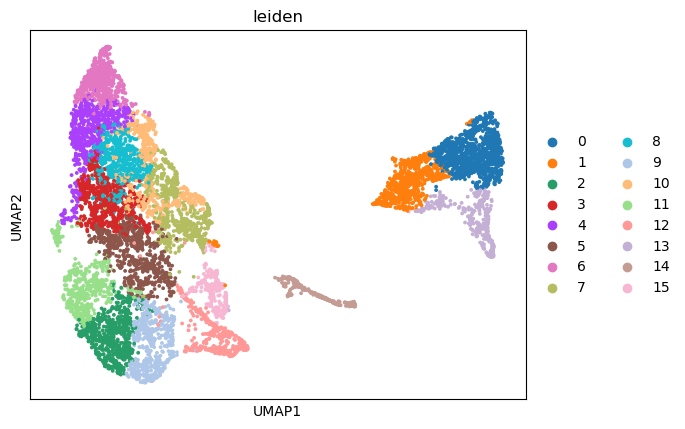

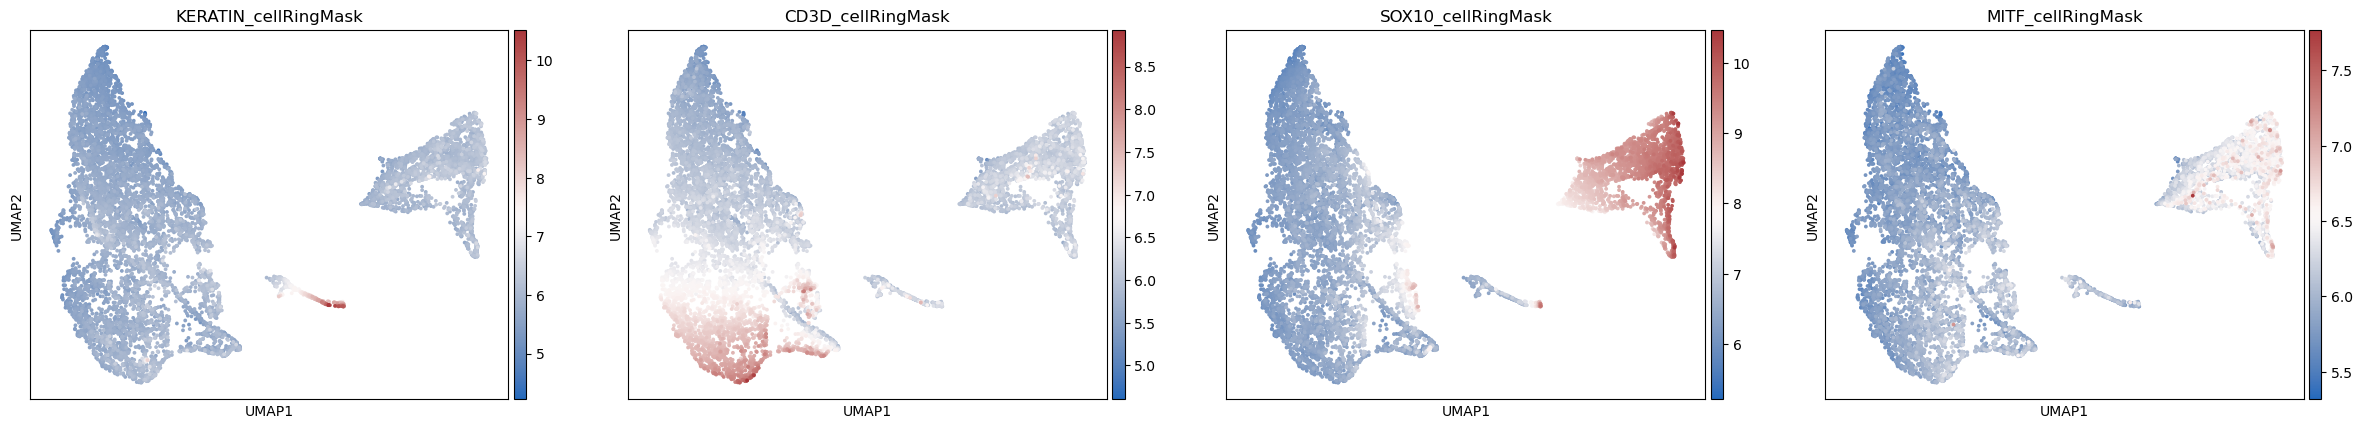

In [164]:
warnings.filterwarnings('ignore')

# Plot
sc.pl.umap(adata_part2, color=['leiden'], 
           cmap= 'vlag', use_raw=False, s=30) 
sc.pl.umap(adata_part2, color=['KERATIN_cellRingMask', 'CD3D_cellRingMask', 
                               'SOX10_cellRingMask','MITF_cellRingMask'], 
           cmap= 'vlag', use_raw=False, s=30) 

# Work with SCIMAP to plot cell-type composition 

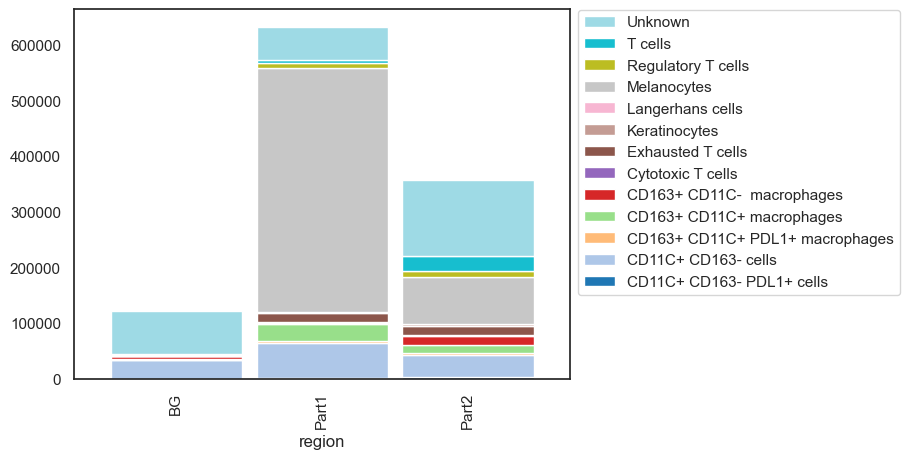

In [150]:
sm.pl.stacked_barplot (adata,
                       x_axis='region',
                       y_axis='phenotype_large_cohort',
                       method='absolute')

# Annimate with SCIMAP

The objective is to create an animation showing transition between UMAP plot and XY coordinate plot in spatial data. See [SCIMAP](https://scimap.xyz/tutorials/6_animate_with_scimap/) for details.

In [167]:
warnings.filterwarnings('ignore')

sm.tl.umap(adata_part1)
sm.hl.animate(adata_part1, color='leiden',
               save_animation = 'MEL1_part1_animation_umap2xy')

In [ ]:
# Open MEL1_part1_animation_umap2xy_scimap.gif to enjoy the animation.
from IPython.display import Image
Image(url='MEL1_part1_animation_umap2xy_scimap.gif') 

MovieWriter imagemagick unavailable; using Pillow instead.


Saving file- This can take several minutes to hours for large files


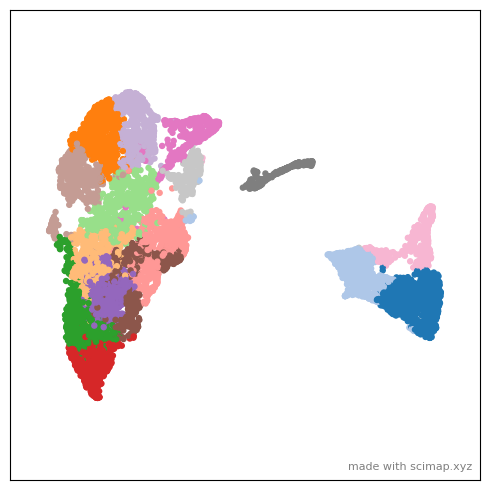

In [162]:
warnings.filterwarnings('ignore')

sm.tl.umap(adata_part2)
sm.hl.animate (adata_part2, color='leiden',
               save_animation = 'MEL1_part2_animation_umap2xy')

In [ ]:
# Open MEL1_part1_animation_umap2xy_scimap.gif to enjoy the animation.
from IPython.display import Image
Image(url='MEL1_part2_animation_umap2xy_scimap.gif') 